# Key Figures

In [46]:
%matplotlib inline
import pandas as pd
import mysql.connector
pd.set_option('display.float_format', lambda x: '%.2f' % x)


## Connect

In [47]:
db_connection = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="",
    database = "pharmagelder"
)

## Load Data

In [48]:
df_list_raw = pd.read_sql("""SELECT 
    sum(tra_value) as sum_value,
    trc_name as category,
    pha_name as pharma,
    tra_year as year,
    rec_type as type
  FROM transaction
  LEFT JOIN pharma ON tra_fk_pharma = pha_id
  LEFT JOIN transaction_category on tra_fk_transaction_category = trc_id
  LEFT JOIN recipient ON rec_id = tra_fk_recipient
  GROUP BY tra_fk_pharma, tra_year, tra_fk_transaction_category, rec_type""", con=db_connection)

df_accu_raw = pd.read_sql("""SELECT 
    sum(acc_value) as sum_value,
    trc_name as category,
    pha_name as pharma,
    acc_year as year,
    acc_type as type
  FROM accumulation
  LEFT JOIN pharma ON acc_fk_pharma = pha_id
  LEFT JOIN transaction_category on acc_fk_transaction_category = trc_id
  GROUP BY acc_fk_pharma, acc_year, acc_fk_transaction_category, acc_type""", con=db_connection)


## Combine

In [49]:
df_list = df_list_raw.copy()
df_accu = df_accu_raw.copy()

#Concat
df_data = pd.concat([df_list, df_accu], sort=False)

In [50]:
df_data.head()

,sum_value,category,pharma,year,type
0,66721.00,registration_fees,Novo Nordisk,2015,hcp
1,246174.00,travel_accommodation,Novo Nordisk,2015,hcp
2,23423.00,registration_fees,Daiichi Sankyo,2015,hcp
3,30390.00,travel_accommodation,Daiichi Sankyo,2015,hcp
4,49002.08,travel_accommodation,Vifor Pharma,2015,hcp


## Total Year

In [51]:
df_group = df_data.groupby('year').agg({'sum_value': 'sum'})
df_group

,sum_value
year,
2015,140514136.22
2016,155584057.78
2017,162335403.11
2018,181432338.37
2019,187122504.25


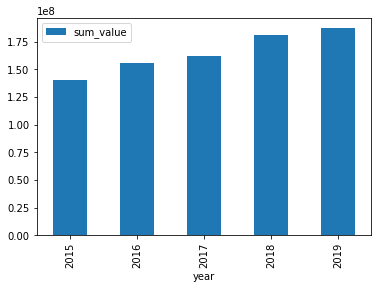

In [52]:
df_group.plot.bar()

## Total Year & Type

In [53]:
df_group = df_data.groupby(['year', 'type']).agg({'sum_value': 'sum'}).reset_index()
df_pivot = pd.pivot_table(df_group, columns='type', index='year', values='sum_value')
df_pivot['total'] = df_pivot.sum(axis = 1)
df_pivot['change_to_previous_year'] = df_pivot['total'] - df_pivot['total'].shift(1)

df_pivot

type,hco,hcp,rnd,total,change_to_previous_year
year,,,,,
2015,75815114.39,16374043.78,48324978.05,140514136.22,nan
2016,91947810.52,13817543.28,49818703.98,155584057.78,15069921.57
2017,91095173.18,12491367.51,58748862.42,162335403.11,6751345.33
2018,96801892.66,12261007.63,72369438.08,181432338.37,19096935.26
2019,106751458.12,11447724.09,68923322.04,187122504.25,5690165.88


In [54]:
df_pivot[['hco', 'hcp', 'rnd']]

type,hco,hcp,rnd
year,,,
2015,75815114.39,16374043.78,48324978.05
2016,91947810.52,13817543.28,49818703.98
2017,91095173.18,12491367.51,58748862.42
2018,96801892.66,12261007.63,72369438.08
2019,106751458.12,11447724.09,68923322.04


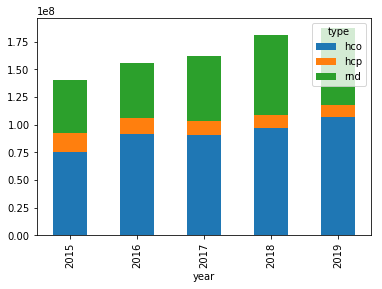

In [55]:
df_pivot[['hco', 'hcp', 'rnd']].plot(kind='bar', stacked=True)

### Add %

In [44]:
df_pivot['hco%'] = 100 / df_pivot['total'] * df_pivot['hco']
df_pivot['hcp%'] = 100 / df_pivot['total'] * df_pivot['hcp']
df_pivot['rnd%'] = 100 / df_pivot['total'] * df_pivot['rnd']

df_pivot[['hco%', 'hcp%', 'rnd%']]

type,hco%,hcp%,rnd%
year,,,
2015,53.96,11.65,34.39
2016,59.10,8.88,32.02
2017,56.12,7.69,36.19
2018,53.35,6.76,39.89
2019,57.05,6.12,36.83
